# Identify stars in images

The star catalog **hip_main.dat** consists of columns separated by | and with no header. Column 2 is the star identifier, column 6 is the magnitude, column 9 and 10 are RA and DE in degrees.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import simulator as sim
import os

In [4]:
star_catalog = sim.StarCatalog('../data/hip_main.dat')

In [5]:
len(star_catalog.star_vectors)

117955

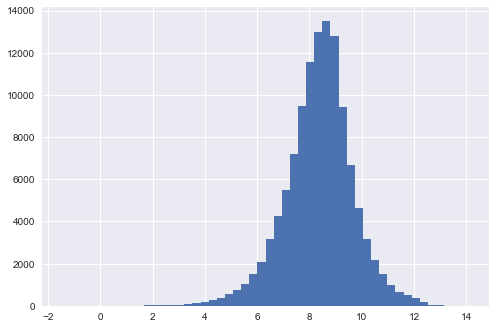

In [6]:
pd.Series(star_catalog.magnitudes).hist(bins=50)

The function *calc_md5* is used to calculate a MD5 checksum from the star catalog to detect changes of the file. In this case the features have to be recalculated.

In [7]:
from hashlib import md5

def calc_md5(file_name):
    fd = open(file_name)
    buffer = fd.read()
    hash = md5(buffer)
    fd.close()
    return hash.hexdigest()

In [8]:
signature = calc_md5('../data/hip_main.dat')

In [9]:
def distance(v):
    return np.sqrt(np.dot(v,v))

def get_parameters(hips,relpos,relmag,distances):
    "Calculate the parameters for the nearest stars"
    param = list(hips)
    param.extend(relmag)
    for index in range(len(hips)-1):
        d1 = distances[index]
        d2 = distances[index+1]
        v1 = relpos[index]
        v2 = relpos[index+1]
        cosalpha = np.dot(v1,v2)/(d1*d2)
        if np.abs(cosalpha) > 1.0:
            cosalpha = min(1.0, cosalpha)
            cosalpha = max(-1.0, cosalpha)
        param.append(cosalpha)
        param.append(d2/d1)
    return np.array(param)

def get_columns(n):
    "Get the columns names of all features"
    cols = []
    for i in range(n):
        cols.append('hip' + str(i+1))
    for i in range(n):
        cols.append('relative_magnitude' + str(i+1))
    if n > 1:
        for i in range(n-1):
            s = str(i+1) + str(i+2)
            cols.append('normalized_angle' + s)
            cols.append('relative_distance_ratio' + s)
    return cols

def get_nearest_stars(ids, dist, n=1):
    "Get the n nearest stars"
    stars = []
    selection = np.array([True]*len(dist))
    while len(stars) < n:
        index = np.argmin(dist[selection])
        identifier = ids[selection][index]
        stars.append(identifier)
        selection[ids == identifier] = False
    return stars
    

In [10]:

# check first if the features have been already calculated
filename = '../data/hip_feat_' + str(signature) + '.csv'
if os.path.exists(filename):
    
    features = pd.read_csv(filename, index_col = 0)

else:

    # find the N closest stars to each star in the catalog
    N = 5
    ids = star_catalog.catalog['HIP'].values
    star_catalog.catalog.index = ids
    cat = zip(ids, star_catalog.star_vectors,star_catalog.magnitudes)
    features = pd.DataFrame(index = ids, 
                            columns = get_columns(N))

    for hip, pos, mag in cat:

        # get the nearest star
        selection = ids != hip
        dist = star_catalog.star_vectors[selection] - pos
        dist2 = np.sum(dist * dist, axis=1)
        nearest_stars = get_nearest_stars(ids[selection],dist2,n=N)
        
        hips = []
        relpos = []
        relmag = []
        distances = []
        for identifier in nearest_stars:
            index = np.where(ids[selection] == identifier)[0][0]
            hips.append(identifier)
            relpos.append(dist[index])
            relmag.append(star_catalog.magnitudes[selection][index] - mag)
            distances.append(np.sqrt(dist2[index]))

        # calculate star measures
        features.ix[hip] = get_parameters(hips, relpos, relmag, distances)


    features.to_csv(filename)

KeyboardInterrupt: 

In [ ]:
features['relative_distance_ratio12'][np.abs(features['relative_distance_ratio12']) < 10].hist(bins=50)

In [11]:
features

,hip1,hip2,hip3,hip4,hip5,relative_magnitude1,relative_magnitude2,relative_magnitude3,relative_magnitude4,relative_magnitude5,normalized_angle12,relative_distance_ratio12,normalized_angle23,relative_distance_ratio23,normalized_angle34,relative_distance_ratio34,normalized_angle45,relative_distance_ratio45
1,51,118035,56,118025,117960,-0.16,-0.5,-0.98,-0.49,0.13,-0.999604,6.0938,-0.361828,1.00219,0.402459,1.2231,0.967359,1.08503
2,118290,118226,118278,238,118181,0.15,-1.24,-1.8,-3.02,-0.41,0.975021,2.84127,0.679617,1.75512,0.422142,1.60299,0.229903,1.02721
3,118230,118183,167,19,118065,0.65,1.28,1.97,-0.08,2.75,0.860188,1.00038,-0.544969,1.55168,-0.571124,1.07115,-0.712459,1.38998
4,118300,118128,289,370,420,1.46,1.53,0.62,-0.93,-0.53,-0.486479,1.7076,-0.85246,1.17877,0.967175,1.39148,0.745677,1.06114
5,48,17,133,222,27,-1.24,-0.4,-1.93,0.3,0.77,-0.666109,2.9121,0.856549,1.35756,-0.0304979,1.19625,0.668026,1.09051
6,118235,118185,224,118053,294,-4.39,-3.66,-3.3,-3.57,-4.42,-0.0174384,1.30096,-0.654612,1.21185,-0.932588,1.24657,-0.959171,1.05601
7,100,118275,118176,118125,118016,-1.2,-1.85,-2.51,-1.76,-1.18,-0.930409,1.00427,-0.30422,1.32937,0.402673,1.20753,0.962844,1.37886
8,42,118232,149,118231,118131,-0.85,-0.19,2.21,-0.11,-4.42,-0.965539,3.60883,-0.547571,1.20073,-0.0595178,1.86481,-0.567299,1.15918
9,70,71,141,74,311,1.83,-0.33,-0.12,1.34,-0.15,0.999983,1.01726,0.00697151,1.72424,0.7095,2.06239,-0.287714,1.00866
10,118306,118189,75,107,117983,-1.31,0.5,-1.17,-3.06,1.28,0.545783,1.90553,-0.41799,1.58356,0.997645,1.28686,-0.71866,1.32422
